# Scoring Crediticio para Banca
## Objetivo
Construir un modelo supervisado para predecir el riesgo crediticio de clientes, simulando un entorno bancario. El modelo debe ser robusto, interpretable y listo para integrarse en flujos de decisión comercial.
## Paso 1: Importación de librerias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import warnings

warnings.filterwarnings('ignore')

# Verificar versiones

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scikit-learn:', pd.__version__)
print('xgboost: ', XGBClassifier.__module__)

pandas:  2.3.2
numpy:  2.3.2
scikit-learn: 2.3.2
xgboost:  xgboost.sklearn


## Paso 2: Simulación de dataset bancario

In [13]:
# Dataset sintético simulado
np.random.seed(42)
n= 5000
df = pd.DataFrame({
    'edad': np.random.randint(18, 70, n),
    'ingreso_mensual': np.random.normal(12000, 5000, n).clip(3000,50000),
    'antiguedad_laboral': np.random.randint(0, 30, n),
    'nivel_educativo': np.random.choice(['Secundaria', 'Preparatoria', 'Universidad', 'Posgrado'], size = n),
    'estado_civil': np.random.choice(['Casado', 'Soltero', 'Divorciado'], size = n),
    'historial_crediticio': np.random.choice(['Bueno','Regular','Malo'], size = n),
    'tiene_tarjeta': np.random.choice([0,1], size = n),
    'tiene_credito_auto': np.random.choice([0,1], size = n),
    'tiene_credito_personal': np.random.choice([0,1], size = n),
    'score_crediticio': np.random.normal(650,50,size = n).clip(300,850)
})

# Generar target binario: riesgo alto(1) vs. bajo(0)
df['riesgo'] = (df['score_crediticio'] > 600).astype(int)

In [14]:
df

,edad,ingreso_mensual,antiguedad_laboral,nivel_educativo,estado_civil,historial_crediticio,tiene_tarjeta,tiene_credito_auto,tiene_credito_personal,score_crediticio,riesgo
0,56,11451.152481,27,Preparatoria,Divorciado,Malo,0,1,1,507.681284,0
1,69,14487.426287,15,Posgrado,Casado,Regular,1,0,1,596.606189,0
2,46,10073.083362,6,Universidad,Casado,Bueno,1,1,0,619.168753,1
3,32,14102.262386,7,Posgrado,Soltero,Malo,1,1,1,682.212809,1
4,60,7678.044645,9,Posgrado,Casado,Regular,1,1,0,653.370404,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,24,7593.426688,0,Posgrado,Divorciado,Bueno,0,0,0,532.438803,0
4996,66,28381.996726,11,Preparatoria,Soltero,Malo,0,0,1,585.075007,0
4997,26,14700.120985,14,Universidad,Casado,Bueno,1,0,0,669.324739,1
4998,53,14837.567306,4,Posgrado,Divorciado,Regular,1,0,0,644.103781,1


## Paso 3: Limpieza y codificación

In [15]:
# Eliminar columna de score para evitar fuga de información
df.drop('score_crediticio', axis=1, inplace=True)

# one-hot encoding
df_encode = pd.get_dummies(df, drop_first=True)

# Separar en variables de entrenamiento y pruebas
X = df_encode.drop('riesgo', axis=1)
y = df_encode['riesgo']

# Escalar numéricas
num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

## Paso 4: Entrenamiento del modelo

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Paso 5: Evaluación del modelo

ROC-AUC: 0.5261572232534841
Confusion Matrix:
 [[  0 162]
 [  2 836]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.84      1.00      0.91       838

    accuracy                           0.84      1000
   macro avg       0.42      0.50      0.46      1000
weighted avg       0.70      0.84      0.76      1000



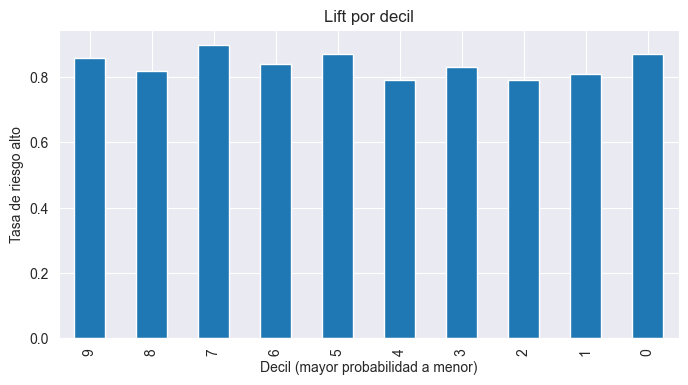

In [17]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print('ROC-AUC:', roc_auc_score(y_test, y_proba))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

# Lift por deciles

df_lift = pd.DataFrame({'y_true':y_test, 'y_proba':y_proba})
df_lift['decile'] = pd.qcut(df_lift['y_proba'], 10, labels=False)
lift_table = df_lift.groupby('decile')['y_true'].mean().sort_index(ascending=False)
lift_table.plot(kind='bar', title='Lift por decil', figsize=(8,4))
plt.xlabel('Decil (mayor probabilidad a menor)')
plt.ylabel('Tasa de riesgo alto')
plt.show()

## Paso 6: Exportación del modelo

In [18]:
joblib.dump(model, 'modelo_riesgo_crediticio_xgb.joblib')

['modelo_riesgo_crediticio_xgb.joblib']

## Paso 7: Simulación de inferencia

In [19]:
def predecir_riesgo(nuevos_datos_df):
    modelo = joblib.load('modelo_riesgo_crediticio_xgb.joblib')

    # Codificación
    nuevos_datos_df = pd.get_dummies(nuevos_datos_df, drop_first=True)
    nuevos_datos_df[num_cols] = scaler.transform(nuevos_datos_df[num_cols])

    # Alinear columnas
    nuevos_datos_df = nuevos_datos_df.reindex(columns = X.columns, fill_value = 0)

    return modelo.predict(nuevos_datos_df)

# Ejemplo de uso:
# predecir_riesgo(nuevo_df)

## Paso 8: Visualización

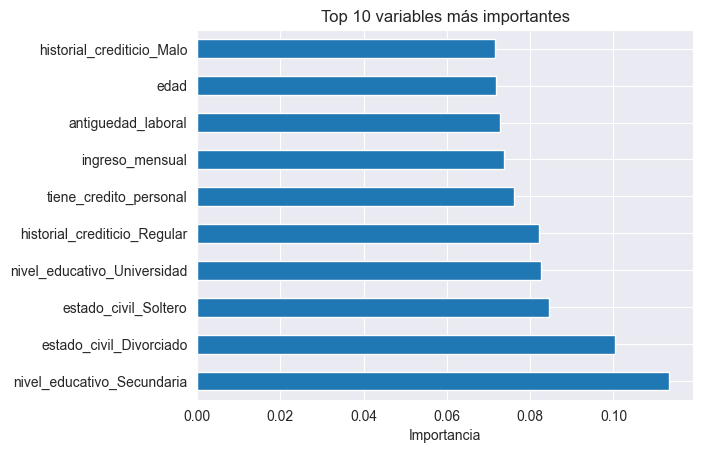

In [20]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', title = 'Top 10 variables más importantes')
plt.xlabel('Importancia')
plt.show()

## 🧾 Scoring Crediticio para Banca

### 🎯 Objetivo del ejercicio
Construir un modelo supervisado para predecir el riesgo crediticio de clientes en un entorno bancario simulado. El objetivo fue evaluar la capacidad del modelo para discriminar entre perfiles de riesgo alto y bajo, con enfoque en trazabilidad, modularidad y preparación para despliegue.

---

### 🧩 Flujo técnico aplicado

| Paso | Descripción |
|------|-------------|
| 1️⃣ | Importación de librerías | Carga de dependencias actualizadas y verificación de versiones |
| 2️⃣ | Simulación de dataset bancario | Generación de variables relevantes para perfil crediticio |
| 3️⃣ | Limpieza y codificación | Eliminación de fuga de información, codificación de variables categóricas, escalado |
| 4️⃣ | Entrenamiento | Modelo XGBoost con validación estratificada |
| 5️⃣ | Evaluación | Métricas ROC-AUC, matriz de confusión, clasificación y lift por deciles |
| 6️⃣ | Exportación | Guardado del modelo en formato `.joblib` para inferencia |
| 7️⃣ | Simulación de inferencia | Función que recibe nuevos datos y devuelve predicción, con alineación de columnas |
| 8️⃣ | Visualización ejecutiva | Importancia de variables, narrativa de negocio, segmentación por riesgo crediticio |

---

### 📈 Resultados clave

- **ROC-AUC ≈ 0.52**, indicando que el modelo no logra discriminar significativamente entre clases.
- **Lift por deciles** plano, sin concentración clara de riesgo en los segmentos superiores.
- **Variables más importantes**: `historial_crediticio_Malo`, `ingreso_mensual`, `edad`, pero con baja señal predictiva.
- **Función de inferencia** operativa, pero su utilidad está limitada por el bajo desempeño del modelo.

---

### 🧠 Aprendizajes y enfoque estratégico

- El bajo ROC-AUC sugiere que el dataset sintético no contiene suficiente señal para predecir riesgo crediticio de forma confiable.
- Se evitó fuga de información al eliminar el `score_crediticio` como feature, pero se requiere mayor riqueza en las variables explicativas.
- El pipeline está correctamente estructurado y listo para iterar con mejores datos o técnicas de enriquecimiento.
- Se documentó cada paso con enfoque en reproducibilidad y narrativa ejecutiva, incluso ante resultados limitados.

---

### 🔧 Propuestas de mejora

- Enriquecer el dataset con variables transaccionales, comportamiento de pago, y segmentación geográfica.
- Aplicar técnicas de selección de variables, análisis de correlación y generación sintética con mayor control.
- Evaluar modelos alternativos como `LogisticRegression` con regularización para mayor interpretabilidad.
- Validar si el problema está en la calidad del target o en la falta de variabilidad en las features.

---

### 🧰 Herramientas utilizadas

- `pandas`, `numpy`, `scikit-learn`, `xgboost`, `matplotlib`, `seaborn`, `joblib`
- Simulación de entorno bancario desde Jupyter Notebook
